# Positional accuracy of a 6-axis Robot Arm

<div style="width: 500px;">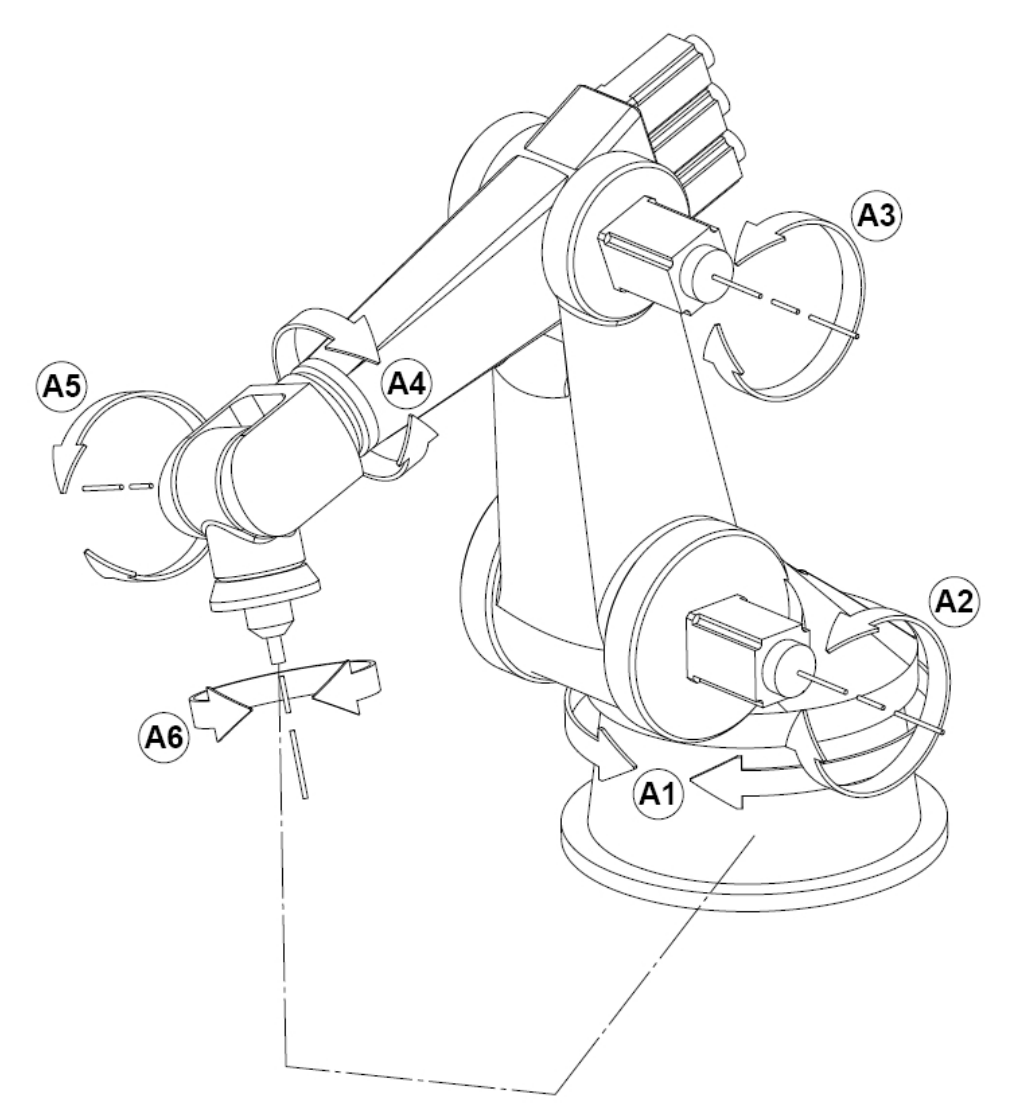</div>

For this project I'm working with a dataset of positional measurements for a 6-axis robot arm with end-effector. We'll start out doing some exploration to get familiar with the data, then perform some basic analyses to identify descriptive statistics and interesting trends in the error. To create this dataset, I commanded the robot to assume unique poses, with each pose defined by the six joint positions, and measured three points on the end effector for each pose in order to determine location and orientation. These measurements can be compared against predicted values for those positions as calculated through a standard forward kinematics model for this robot arm.

Let's start exploring the data!
## Setup

In [37]:
# import libraries and set defaults
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('precision',3) # set display precision to 3; note that higher precision is still preserved
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
sns.set(style="white", context="notebook")
import statsmodels.api as sm
import statsmodels.formula.api as smformula

## First Look

In [2]:
# load robodata.csv into dataframe
robodata = pd.read_csv('robodata.csv')
robodata.head()

,A1,A2,A3,A4,A5,A6,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3,xn1,yn1,zn1,xn2,yn2,zn2,xn3,yn3,zn3,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
0,25.3,-69.4,90.1,-175.0,10.6,22.1,3569.589,1667.628,1664.441,3280.233,1689.938,1807.605,3468.103,1923.943,1495.405,3569.535,1667.530,1664.575,3280.189,1689.935,1807.710,3468.090,1923.822,1495.450,0.054,0.098,-0.134,0.175,0.045,0.003,-0.104,0.114,0.013,0.121,-0.045,0.130
1,18.3,-90.9,57.1,-174.1,-68.7,67.3,2782.271,2678.499,1055.741,2640.343,2935.808,1191.244,2768.137,2855.376,785.392,2782.430,2678.874,1055.892,2640.516,2936.218,1191.336,2768.246,2855.677,785.487,-0.158,-0.375,-0.151,0.434,-0.173,-0.410,-0.092,0.455,-0.109,-0.301,-0.095,0.334
2,16.1,-111.7,96.6,-171.9,-42.7,145.1,2655.783,2264.947,900.780,2628.147,2543.976,739.257,2433.991,2160.061,690.104,2655.858,2265.032,900.872,2628.253,2544.055,739.333,2434.038,2160.148,690.220,-0.075,-0.085,-0.093,0.146,-0.106,-0.080,-0.077,0.153,-0.047,-0.087,-0.116,0.153
3,23.6,-97.2,52.8,-170.8,-71.2,82.5,2405.550,3060.262,1273.083,2262.407,3344.750,1330.362,2389.892,3152.920,963.656,2405.628,3060.496,1273.170,2262.474,3345.000,1330.402,2389.934,3153.116,963.728,-0.079,-0.234,-0.087,0.262,-0.067,-0.250,-0.040,0.262,-0.042,-0.196,-0.072,0.213
4,25.3,-66.9,96.0,-170.6,23.1,100.8,3576.144,1517.902,1596.277,3394.300,1784.808,1576.172,3465.213,1460.642,1297.949,3576.139,1517.828,1596.307,3394.316,1784.748,1576.166,3465.193,1460.531,1298.000,0.005,0.074,-0.030,0.080,-0.016,0.060,0.006,0.062,0.020,0.111,-0.050,0.124


In [3]:
robodata.describe()

,A1,A2,A3,A4,A5,A6,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3,xn1,yn1,zn1,xn2,yn2,zn2,xn3,yn3,zn3,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
count,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,1.990e+02,1.990e+02,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000
mean,23.768,-79.033,80.067,4.226,-0.501,165.310,2781.660,1978.804,1271.983,2615.590,2160.558,1261.650,2689.204,2021.012,1055.019,2781.663,1978.807,1271.984,2615.598,2160.548,1261.646,2689.207,2021.014,1055.021,-3.422e-03,-2.500e-03,-0.001,0.154,-0.008,0.010,0.003,0.157,-0.003,-0.002,-0.001,0.154
std,33.497,32.507,31.795,103.877,62.929,98.473,739.376,690.224,816.225,736.573,712.233,883.140,789.155,744.179,840.629,739.357,690.223,816.213,736.576,712.228,883.140,789.149,744.172,840.618,9.508e-02,1.066e-01,0.096,0.075,0.096,0.115,0.092,0.081,0.094,0.109,0.095,0.076
min,-45.000,-129.000,10.000,-175.000,-100.000,0.000,1249.021,490.556,-665.440,1068.988,489.066,-917.488,999.905,290.948,-968.552,1249.114,490.421,-665.502,1068.803,489.017,-917.501,1000.006,291.022,-968.573,-2.652e-01,-3.746e-01,-0.322,0.032,-0.267,-0.410,-0.260,0.024,-0.370,-0.301,-0.289,0.040
25%,-4.000,-105.900,56.350,-87.300,-66.350,84.400,2252.928,1498.596,724.479,2113.314,1650.103,627.053,2088.453,1538.307,477.714,2253.049,1498.644,724.515,2113.335,1650.082,626.976,2088.481,1538.374,477.744,-6.450e-02,-6.307e-02,-0.066,0.101,-0.068,-0.058,-0.061,0.099,-0.058,-0.077,-0.063,0.092
50%,24.300,-82.400,86.200,13.900,9.700,161.800,2703.066,1883.070,1353.896,2563.854,2118.960,1284.311,2621.814,1974.704,1143.295,2703.161,1882.955,1353.754,2564.058,2118.882,1284.288,2621.688,1974.610,1143.240,1.297e-04,-7.151e-05,-0.005,0.144,-0.015,0.014,0.001,0.140,0.004,-0.010,0.002,0.138
75%,50.450,-59.950,107.150,98.200,61.250,227.550,3365.697,2461.316,1925.056,3193.724,2631.866,1956.620,3250.262,2594.306,1718.306,3365.665,2461.388,1925.086,3193.634,2631.963,1956.709,3250.232,2594.377,1718.238,5.506e-02,6.076e-02,0.061,0.195,0.047,0.075,0.059,0.205,0.055,0.066,0.055,0.189
max,90.000,16.300,125.000,175.000,100.000,359.000,4292.948,3526.632,2901.797,4158.293,3686.011,3064.844,4318.107,3741.343,2656.582,4292.996,3526.580,2901.537,4158.363,3685.891,3064.661,4318.180,3741.236,2656.357,2.866e-01,2.745e-01,0.331,0.441,0.273,0.443,0.273,0.552,0.260,0.301,0.288,0.398


## Notes on the Dataset

Each row of the dataset represents the robot in a single, unique pose, and there is data for 199 poses. For each pose, we have 
* **columns 1-6, (A1, A2, A3, A4, A5, A6), the joint angles the robot was commanded to** - angles that the robot was commanded to drive each axis to, in degrees. The angles "A1" through "A6" correspond to the angles "A1" through "A6" in the cartoon image above above.
* **columns 7-15, (XA, YA, ZA), the *actual/measured* location of the end effector** - (x, y, z) coordinates (in mm) of each of the three points on the end effector (sufficient to determine not just location but also orientation of robot's toolpoint)
* **columns 16-24, (XN, YN, ZN), the *nominal/expected* location of the end effector** - expected (x, y, z) coordinates (in mm) of the same three points were calculated  by feeding the joint positions to a forward kinematics model configured with nominal values for this robot (though not calibrated for this particular robot nor compensated for it's installation (that's actually the purpose the data was captured for!))
* **columns 25-36, (dx, dy, dz, err), the error in the kinematic model's prediction**  - (dx, dy, dz) are the coordinates (in mm) of the resultant vector if you subtract the nominal/expected position from the actual/measured position (i.e. the 3D error in the model), and "err" is the magnitude of that vector.

## Notes on Methodology

All measurements were made using a high precision laser position tracker, returning the coordinates of these points in a Cartesian coordinate system to a 3-sigma accuracy of +/- 0.025 mm (i.e. 99.7% of measurements are within 0.025 mm of the true value). The tracker was located approximately 5 meters from the base of the robot and centered within the travel of the A1 axis.

The coordinate frame is aligned such that:
* X+ points in the direction of A1 = 0.
* Y+ is vertical, aligned to gravity; note that the robot is mounted on an imperfect surface, so this is not perfectly coincident with the vector of the A1 axis.
* Z+ is determined by the right-hand-rule
* The origin is defined as being coincident with the bottom surface of the base beneath the A1 joint, and coincident with the vector of the A1 axis.

## Divide and Conquer
It's unwieldy to look at the data all in one giant table that way. Let's split it up into a handful of dataframes according to the breakdown described above, then start asking some questions and seeing what insights come up.

In [4]:
# make dataframe containing just the joint positions for each pose
joints = robodata.iloc[:, 0:6]

# make dataframe containing just the measured positions for each pose
actuals = robodata.iloc[:, 6:15]

# split dataframe even further into a frame for each reference point
act_pt1 = actuals.iloc[:, 0:3] # measured (x, y, z) values for pt1
act_pt2 = actuals.iloc[:, 3:6] # measured (x, y, z) values for pt2
act_pt3 = actuals.iloc[:, 6:9] # measured (x, y, z) values for pt3

# make dataframe containing just the nominal positions for each pose
nominals = robodata.iloc[:, 15:24]

# split dataframe even further into a frame for each reference point
nom_pt1 = nominals.iloc[:, 0:3] # nominal (x, y, z) values for pt1
nom_pt2 = nominals.iloc[:, 3:6] # nominal (x, y, z) values for pt2
nom_pt3 = nominals.iloc[:, 6:9] # nominal (x, y, z) values for pt3

# make dataframe containing just the errors of the positions for each pose
errors = robodata.iloc[:, 24:]

# split dataframe even further into a frame for each reference point
err_pt1 = errors.iloc[:, 0:4] # error (dx, dy, dz, err) values for pt1
err_pt2 = errors.iloc[:, 4:8] # error (dx, dy, dz, err) values for pt2
err_pt3 = errors.iloc[:, 8:12] # error (dx, dy, dz, err) values for pt3

# Start asking questions!
## The joint positions were supposedly generated randomly, but how random are they?

In [5]:
joints.head()

,A1,A2,A3,A4,A5,A6
0,25.3,-69.4,90.1,-175.0,10.6,22.1
1,18.3,-90.9,57.1,-174.1,-68.7,67.3
2,16.1,-111.7,96.6,-171.9,-42.7,145.1
3,23.6,-97.2,52.8,-170.8,-71.2,82.5
4,25.3,-66.9,96.0,-170.6,23.1,100.8


In [6]:
joint_stats = joints.describe().loc[['mean','std', 'min', 'max']] # grab some informative statistics
joint_stats.loc['range'] = joints.max() - joints.min() # add a row containing the range of travel of each joint
joint_stats

,A1,A2,A3,A4,A5,A6
mean,23.768,-79.033,80.067,4.226,-0.501,165.310
std,33.497,32.507,31.795,103.877,62.929,98.473
min,-45.000,-129.000,10.000,-175.000,-100.000,0.000
max,90.000,16.300,125.000,175.000,100.000,359.000
range,135.000,145.300,115.000,350.000,200.000,359.000


The above statistics about the joint positions are somewhat informative, particularly the min, max and range attributes, as those tell us about the actual limits of travel for each joint. The next thing I want to know about is the actual distribution of joint positions throughout their allowable range, and though the mean and std hint at this, they're a bit lacking in information. Let's create a scatter matrix from this data to investigate both the spread of each individual joint's positions as well as see if there's any apparent relationships between our joints. 

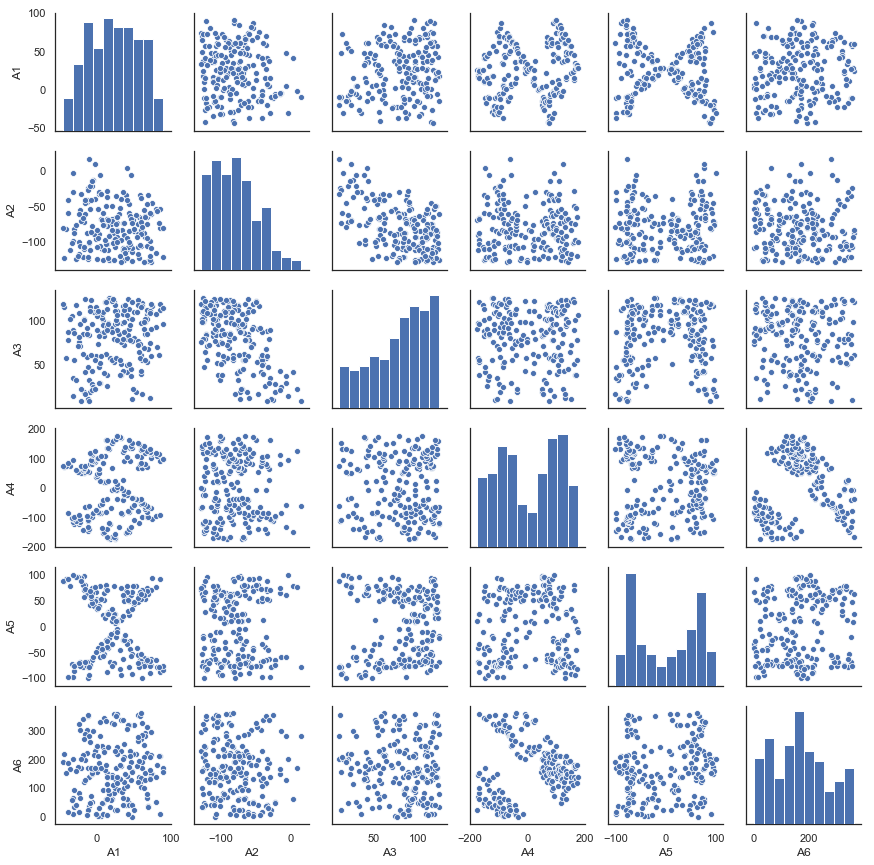

In [180]:
# create pairplot of joint positions
p = sns.pairplot(joints)
sns.set(style="white", context="notebook")
p.fig.set_size_inches(12,12) # sized to fit on my screen; adjust as needed

Pow! Okay. Once we're over the information overload we can start actually gleaning some information from this high-level view of our joint data. Despite the fact that all of the poses the robot took on were "randomly generated", it's quite clear that they're not uniformly distributed across the joint ranges. Let's talk through some quick observations about each axis, and then go into some of the real life conditions on the ground that explain them:

* **A1** - appears nearly normally distributed. The mean is actually just barely a degree away from the actual center! Looking at the pairplots, it appears that there is some significant interplay between A1 and and A4 and A5 axes. The plots for the remaining axes are suggestive of weak relationships.
* **A2 and A3** - these axes present themselves similarly, though opposite. A2 is distinctly right-skewed and tapers off to nearly 0 for high angles. A3 is *left*-skewed and actually flattens out to approximately uniform representation for low angles. Observing their pairplot, we can see that there's actually some significant correlation between A2 and A3.
* **A4** - symmetric bimodal distribution with minimal representation near 0. Strong relationships apparent with the A1 and A6 axes, and minimal interplay with A2, A3, and A5.
* **A5** - another symmetric bimodal distribution, though this one is a bit sharper and a bit less symmetric than A4's. Distinct relationships are evident with A1, A2, and A3.
* **A6** - this distribution is one I'm most inclined to call random, or at least nearly so. Even still, there does appear to be some significant relationship with A4, while the rest appear mostly independent of A6.

Fortunately, most of these observations can be readily explained by some physical understanding of how each joint  affects the overall position of the robot, as well as the context within which the data was taken. The first important detail is that all of these joints are connected **in series**, much like a human arm starting at the shoulder. The further you move down the kinematic chain, the more the joints location has been impacted by previous joints. To leverage the arm analogy, A1 and A2 are in the shoulder. A1 swings the arm side-to-side and A2 elevates the arm up and down (where 0 is parallel to the ground and -90 is straight up in the air). The shoulder has no ability to twist, like ours do, and is oriented such that the elbow, A3, can only swing the forearm up and down (the rotational axes of A2 and A3 are parallel). A4 and A5 are in the "wrist" of the robot, where A4 is ability of the wrist to twist (nearly a full 360 degrees!), and A5 is the motion of a forward-and-back flit of the wrist. A6 is where you mount all the action on a robot arm, the fingers, if you will. For this robot, we can think of it as having a flat plate on the end capable of infinite rotation.

As I previously hinted at, each of the 199 poses the robot struck was "randomly generated." I put that in quotes, however, not just because I used a pseudorandom number generator. I actually generated several hundred thousand unique poses in order to get to these 199 realized positions, and had to discard the others because they were not actually compatible with the conditions on the ground, i.e. that the robot was located in a confined work-cell containing physical obstacles within the envelope of travel, and a requirement that all poses have line-of-sight with all three of the reference points being measured on the end effector, and don't require that the robot occupy the same space as another object.

I won't belabor it even further, but suffice it to say that these constraints combined with the kinematic layout of the robot explain most of the irregularity in our joint positions.

## How were the reference positions distributed throughout the space?
To answer this question, let's look at some basic stats about the measured reference positions and then generate three orthogonal views of the work envelope to see our points are spread relatively evenly around the space. Because all three reference move together on the same piece of structure, we'll just look at data for a single point for much of this.

In [8]:
# print out some useful stats about the measured reference positions
actuals_stats = actuals.describe().loc[['mean','std', 'min', 'max']]
actuals_stats.loc['range'] = actuals.max() - actuals.min() # add a row containing the range of travel of each joint
actuals_stats

,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3
mean,2781.660,1978.804,1271.983,2615.590,2160.558,1261.650,2689.204,2021.012,1055.019
std,739.376,690.224,816.225,736.573,712.233,883.140,789.155,744.179,840.629
min,1249.021,490.556,-665.440,1068.988,489.066,-917.488,999.905,290.948,-968.552
max,4292.948,3526.632,2901.797,4158.293,3686.011,3064.844,4318.107,3741.343,2656.582
range,3043.927,3036.076,3567.237,3089.306,3196.945,3982.332,3318.202,3450.395,3625.134


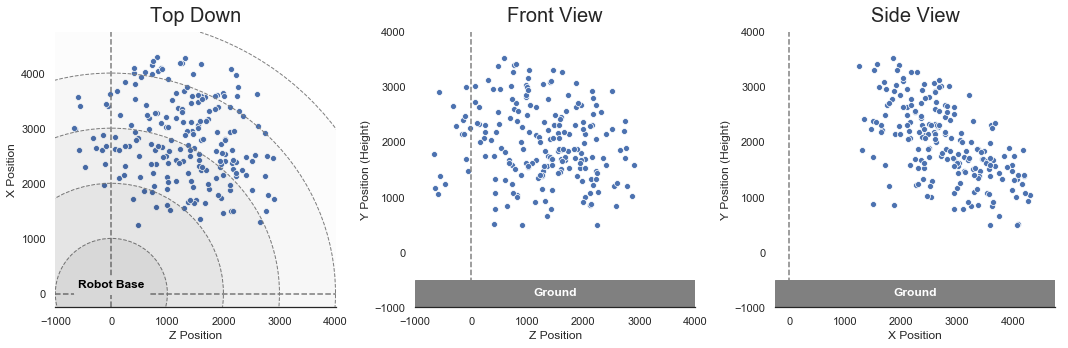

In [181]:
# import some helpers
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from matplotlib.patheffects import withStroke

# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=False)
sns.despine(left=True)
sns.set(style="white", context="notebook")

# define circle-drawing function
def circle(x, y, radius=0.15, fill=0.0125, linestyle='dashed'):
    circle = Circle((x, y), radius, clip_on=True, zorder=10, linewidth=1, ec='grey', 
                    facecolor=(0, 0, 0, fill), linestyle=linestyle)
    ax.add_artist(circle)

# define text-drawing function
def text(x, y, text, backgroundcolor="white", color='black'):
    ax.text(x, y, text, backgroundcolor=backgroundcolor,
            ha='center', va='top', weight='bold', color=color)

# define various labels and parameters to use below
labels = ['Top Down', 'Front View', 'Side View']
xlabels = ['Z Position', 'Z Position', 'X Position']
ylabels = ['X Position', 'Y Position (Height)', 'Y Position (Height)']
x = ['za1', 'za1', 'xa1']
y = ['xa1', 'ya1', 'ya1']
ground = -500

# plot scatter plots showing distribution of reference points in Cartesian space
for i, ax in enumerate(axes):
    sns.scatterplot(x=x[i], y=y[i], data = act_pt1, ax=ax)
    ax.set_title(labels[i], fontsize=20, verticalalignment='bottom')
    ax.axvline(0, color='grey', linestyle='dashed')
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])
    
    # define plot-specific features
    if i == 0:
        ax.set_xlim(-1000, 4000)
        ax.set_ylim(-250, 4750)
        ax.axhline(0, color='grey', linestyle='dashed')
        for c in range(5): # concentric circles about the robot base
            circle(0, 0, radius=1000 * (c + 1), fill=0.01 * (5 - c) ) # draw circle to indicate robot location
        text(0, 250, 'Robot Base')
    elif i == 1:
        ax.set_xlim(-1000, 4000)
        ax.set_ylim(-1000, 4000)
        ax.axhspan(ymin=-1000, ymax=ground, color='grey')
        text(1500, -650, 'Ground', backgroundcolor='grey', color='white')

    else:
        ax.set_xlim(-250, 4750)
        ax.set_ylim(-1000, 4000)
        ax.axhspan(ymin=-1000, ymax=ground, color='grey')
        text(2250, -650, 'Ground', backgroundcolor='grey', color='white')

plt.tight_layout()

In the plots above, we see the spread of data from three orthogonal views with a rough representation of the locations of the robot base and laser tracker used for measurements to help orient in the space. A few takeaways:
- Points tend to be clustered in a cloud centered between the robot and the tracker. 
- The point cloud is approximately 3 meters across and roughly spherical. 
- We can make out the limits of the fully extended arm pretty well in the Side View plot
- The points are generally well distributed in Cartesian space
Let's check it out a little closer with some histograms.

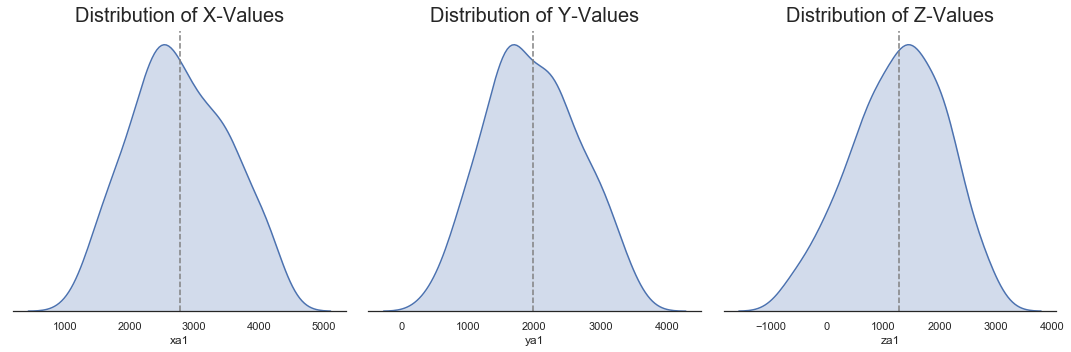

In [11]:
# create histograms of x, y, and z values 
# set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=False)
sns.despine(left=True)
labels = ('Distribution of X-Values', 'Distribution of Y-Values', 'Distribution of Z-Values')
pts = ('xa1', 'ya1', 'za1')

# plot filled kernel density estimates
for i, ax in enumerate(axes):
    sns.distplot(actuals[pts[i]], hist=False, kde_kws={"shade": True}, ax=ax)
    ax.axvline(actuals[pts[i]].mean(), color='grey', linestyle='dashed')
    ax.set_title(labels[i], fontsize=20, verticalalignment='bottom')

plt.setp(axes, yticks=[])
plt.tight_layout()

## How normal are those distributions, really?
Not that I expect to use this information in any meaningful way but let's make some normal Q-Q plots of our X, Y, and Z values to compare the spread of our data to a standard normal distribution and see how normal the data really is. For funsies.

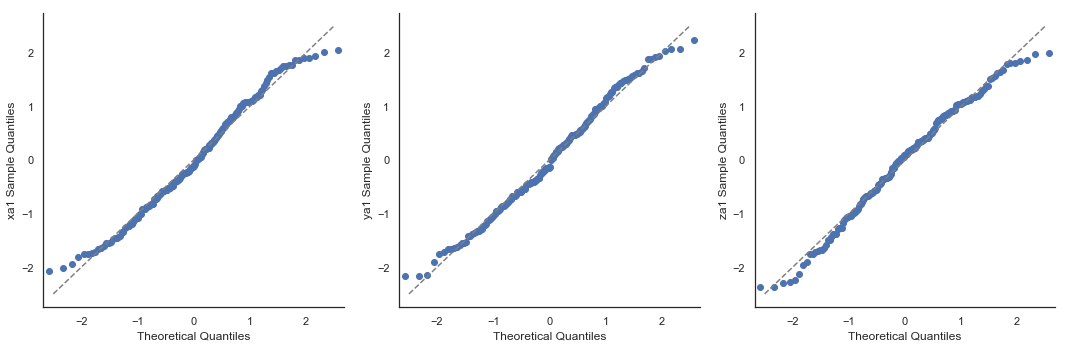

In [182]:
# Create pairplot of reference positions
# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set(style="white", context="notebook")
sns.despine()

# Plot Q-Q plots of each
for i in range(3):
    sm.qqplot(actuals.iloc[:,i], fit=True, ylabel=(str(actuals.columns[i]) + " Sample Quantiles"), ax=axes[i])
    axes[i].plot([-2.5,2.5],[-2.5,2.5], color='grey', linestyle='dashed')
plt.tight_layout()
plt.show()

They're quite normal! Since a truly normal distribution would yield a y = x relationship, we can say that these actually follow that relationship quite well, only really deviating on the edges of our data.

## So, how bad is the error in our kinematic model?
Okay, there are a lot of ways to answer that question. And we'll work through some, but let me first quickly describe our error values. dx, dy, and dz represent the difference between where we measured a reference point and where our kinematic model predicted it would be based on the given joint positions. The err value reported for each point is simply the magnitude of its three error vectors (hence it's always positive and non-directional). As with before, all reported values are in metric.

Let's start just by looking at our basic summary statistics.

In [13]:
error_stats = errors.describe().loc[['mean','std', 'min', 'max']]
error_stats.loc['range'] = errors.max() - errors.min() # add a row containing the range of errors for each column
error_stats

,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
mean,-0.003,-0.002,-0.001,0.154,-0.008,0.010,0.003,0.157,-0.003,-0.002,-0.001,0.154
std,0.095,0.107,0.096,0.075,0.096,0.115,0.092,0.081,0.094,0.109,0.095,0.076
min,-0.265,-0.375,-0.322,0.032,-0.267,-0.410,-0.260,0.024,-0.370,-0.301,-0.289,0.040
max,0.287,0.275,0.331,0.441,0.273,0.443,0.273,0.552,0.260,0.301,0.288,0.398
range,0.552,0.649,0.654,0.409,0.540,0.853,0.533,0.528,0.630,0.602,0.577,0.358


### Initial Observations
- By looking at how close our d-values are to 0, we can tell that our error is pretty well centered. Note that this is actually somewhat expected, as the laser tracker's coordinate system was generating by performing a best fit of measured positions to the robot's coordinate system.
- Our maximum 3-dimensional error is 0.552 mm, on the 2nd reference point.
- We see the largest range of errors in dy2, spanning 0.853 mm

## Searching for signal in the noise
We're really getting to the meat of the analysis, now. When I think about assessing the quality of the model, the question I'm really asking is if I can identify any consistent patterns in the error. If we can't find any trends within the error than all we can really do is chock it up as noise, if, however, we *can* distinguish some signal in the noise, then we can potentially incorporate that into our kinematic model to improve our accuracy. We'll begin our hunt with a plethora of plots, as described below.

- 2D radius vs error
- 3D radius vs error
- radius vs height with error as color or size
- measured x, y, and z values vs error
- each joint position vs error
- heatmap of error over area

### Distance vs error
To make the graphs calling for radii measurements, we'll first have to calculate those values since they don't actually come in the original dataset. I'll calculate both the 2D distance to each point, i.e. the distance from our y-axis to each measured point, as well as the 3D distance to each point, so from the origin rather than the y-axis. 

In [161]:
# calculate radial distance (from Y-axis) to each measured location
act_radius1 = np.linalg.norm(act_pt1.iloc[:,[0,2]], axis=1)
act_radius2 = np.linalg.norm(act_pt2.iloc[:,[0,2]], axis=1)
act_radius3 = np.linalg.norm(act_pt3.iloc[:,[0,2]], axis=1)

# create radius dataframe
act_radii = pd.DataFrame({'pt1 radius':act_radius1, 'pt2 radius':act_radius2, 'pt3 radius':act_radius3})
display(act_radii.describe().loc[['count','mean','std', 'min', 'max']])

# calculate distance from robot base (origin) to each measured position
act_mag1 = np.linalg.norm(act_pt1, axis=1)
act_mag2 = np.linalg.norm(act_pt2, axis=1)
act_mag3 = np.linalg.norm(act_pt3, axis=1)

# create radius dataframe
act_mags = pd.DataFrame({'pt1 distance':act_mag1, 'pt2 distance':act_mag2, 'pt3 distance':act_mag3})
display(act_mags.describe().loc[['count','mean','std', 'min', 'max']])

,pt1 radius,pt2 radius,pt3 radius
count,199.000,199.000,199.000
mean,3180.118,3051.572,3029.736
std,671.936,662.581,700.569
min,1335.810,1215.165,1059.741
max,4592.707,4420.954,4392.845


,pt1 distance,pt2 distance,pt3 distance
count,199.000,199.000,199.000
mean,3844.573,3842.904,3755.234
std,414.950,393.075,449.862
min,2657.452,2726.886,2611.352
max,4832.704,4876.411,4627.838


In [170]:
# regression function
def regress(x, y):
    # add constant to x
    x = sm.add_constant(x)
    
    # fit regression model
    results = sm.OLS(y, X).fit()

    # Inspect the results
    print(y.name, '\n', results.params, '\n')
    return results

# make some pointers to the data
distances = (act_radius1, act_radius2, act_radius3, act_mag1, act_mag2, act_mag3)
errs = (errors['err1'], errors['err2'], errors['err3'])

# run ordinary least squares regression on all six pairs; loads of reports will print below
regressions = [regress(x, errs[i%3]) for i, x in enumerate(distances)]
b = [regression.params for regression in regressions]
regressions[0].summary()

err1 
 const    2.184e-01
x1      -2.012e-05
dtype: float64 

err2 
 const    2.603e-01
x1      -3.255e-05
dtype: float64 

err3 
 const    2.231e-01
x1      -2.160e-05
dtype: float64 

err1 
 const    2.184e-01
x1      -2.012e-05
dtype: float64 

err2 
 const    2.603e-01
x1      -3.255e-05
dtype: float64 

err3 
 const    2.231e-01
x1      -2.160e-05
dtype: float64 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   err1   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6.663
Date:                Thu, 18 Oct 2018   Prob (F-statistic):             0.0106
Time:                        01:43:52   Log-Likelihood:                 237.60
No. Observations:                 199   AIC:                            -471.2
Df Residuals:                     197   BIC:                            -464.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2184      0.025      8.623      0.000       0.168       0.268
x1         -2.012e-05   7.79e-06     -2.581      0.011   -3.55e-05   -4.75e-06
==============================================================================
Omnibus:                       34.442   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.670
Skew:                           0.988   Prob(JB):                     9.94e-12
Kurtosis:                       4.486   Cond. No.                     1.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

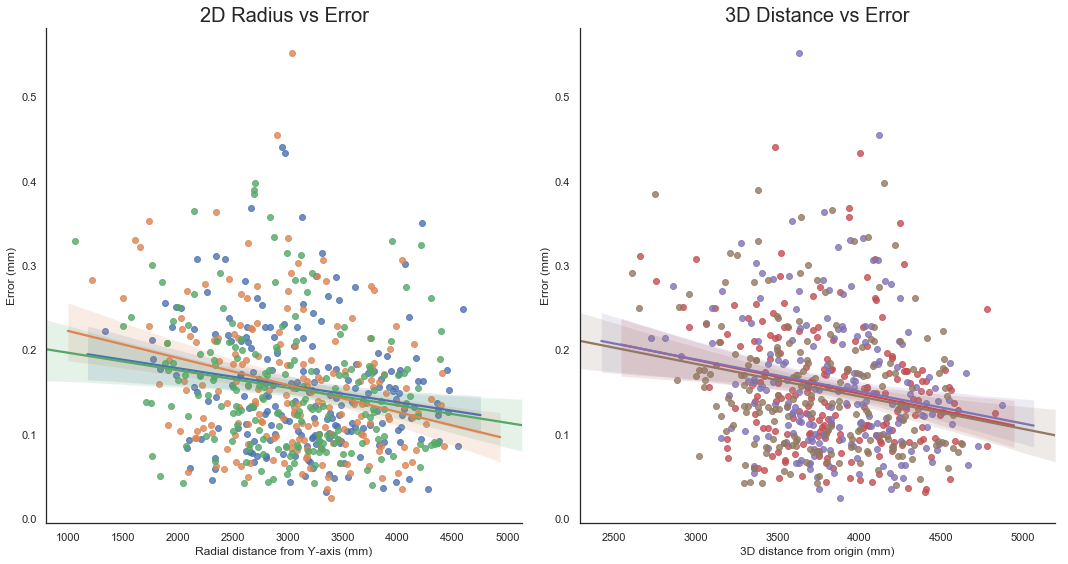

In [184]:
# set up figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
sns.despine()
sns.set(style="white", context="notebook")

# plot each dataset
for i, x in enumerate(distances):
    sns.regplot(x, errs[i%3], ax=[ax1, ax2][i//3])
    
# axis 1 definitions
ax1.set_title("2D Radius vs Error", fontsize=20)
ax1.set_xlabel("Radial distance from Y-axis (mm)")
ax1.set_ylabel("Error (mm)")

# axis 2 definitions
ax2.set_title("3D Distance vs Error", fontsize=20)
ax2.set_xlabel("3D distance from origin (mm)")
ax2.set_ylabel("Error (mm)")
  
# nicer screen formatting
plt.tight_layout()

### Radius vs height with error as color or size

### X, Y, and Z values vs error

### Joint position vs error

### Heatmap of error over area

## Can we detect outliers by looking at variation in the distance between our reference points?
Because the three toolpoints are all mounted to the same rigid fixture, they actually move together through space. This means that, theoretically, the distance between each measurement point should remain constant even as the position and orientation of the robot moves throughout space. Verifying this could be a good way to identify outliers, which in this case could mean erroneous measurements that ought to be discarded from future analysis.

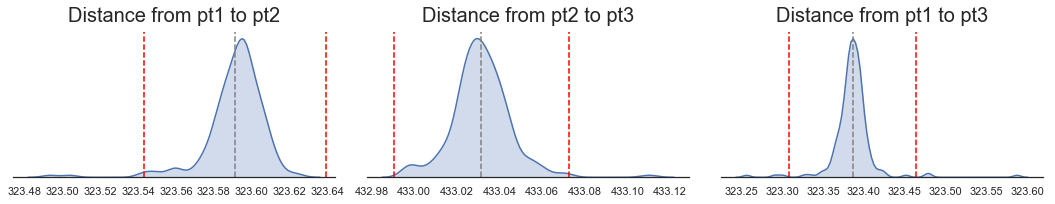

In [185]:
# calculate difference between (x, y, z) values of each point as vectors pointing from 1 to 2, 2 to 3, and 1 to 3
vec12 = pd.DataFrame(act_pt1.values-act_pt2.values, columns=['x12', 'y12', 'z12'])
vec23 = pd.DataFrame(act_pt2.values-act_pt3.values, columns=['x23', 'y23', 'z23'])
vec13 = pd.DataFrame(act_pt1.values-act_pt3.values, columns=['x13', 'y13', 'z13'])

# calculate magnitudes of the difference vectors
mag12 = np.linalg.norm(vec12, axis=1)
mag23 = np.linalg.norm(vec23, axis=1)
mag13 = np.linalg.norm(vec13, axis=1)

# set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3), sharex=False)
sns.despine(left=True)
labels = ('Distance from pt1 to pt2', 'Distance from pt2 to pt3', 'Distance from pt1 to pt3')
vec = (mag12, mag23, mag13)

# plot filled kernel density estimates
for i, ax in enumerate(axes):
    sns.distplot(vec[i], hist=False, kde_kws={"shade": True}, ax=ax)
    ax.axvline(vec[i].mean(), color='grey', linestyle='dashed')
    ax.axvline(vec[i].mean() + 3 * vec[i].std(), color='red', linestyle='dashed')
    ax.axvline(vec[i].mean() - 3 * vec[i].std(), color='red', linestyle='dashed')
    ax.set_title(labels[i], fontsize=20, verticalalignment='bottom')

plt.setp(axes, yticks=[])
plt.tight_layout()

In [186]:
# generate a boolean mask to grab outliers out of our dataframes, where outlier is being defined as any pose where the
# distance between any two of the reference points is greater than 3 standard deviations from the mean distance

outlier_mask = ((np.abs((mag12 - np.mean(mag12))) > (3 * np.std(mag12))) | 
                (np.abs((mag23 - np.mean(mag23))) > (3 * np.std(mag23))) | 
                (np.abs((mag13 - np.mean(mag13))) > (3 * np.std(mag13))))

# print out outlier data
robodata[outlier_mask]

,A1,A2,A3,A4,A5,A6,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3,xn1,yn1,zn1,xn2,yn2,zn2,xn3,yn3,zn3,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
20,46.7,-6.3,37.9,-133.8,61.6,128.3,3614.062,833.013,2591.028,3390.223,940.326,2383.518,3486.851,542.761,2525.608,3614.029,833.029,2591.201,3390.189,940.363,2383.626,3486.968,542.936,2525.765,0.033,-0.015,-0.172,0.176,0.034,-0.038,-0.109,0.120,-0.117,-0.175,-0.156,0.262
51,-4.7,-12.7,25.5,-86.0,-60.1,298.6,4292.948,1045.353,818.739,3976.251,1106.138,791.949,4318.107,1242.748,563.934,4292.996,1045.246,818.777,3976.314,1106.096,791.910,4318.180,1242.701,563.911,-0.048,0.107,-0.037,0.123,-0.063,0.042,0.039,0.085,-0.073,0.046,0.023,0.090
71,-10.7,16.3,10.1,-60.7,-77.9,278.9,4087.601,505.773,398.490,3765.667,489.066,369.996,4075.535,609.696,92.631,4087.825,505.761,398.571,3765.934,489.017,369.987,4075.757,609.858,92.635,-0.224,0.013,-0.081,0.239,-0.267,0.049,0.009,0.271,-0.221,-0.162,-0.004,0.274
73,4.4,-5.7,29.6,-58.4,-59.4,281.3,4265.014,927.111,1321.563,3944.756,962.512,1291.553,4272.441,1047.053,1021.436,4265.135,927.080,1321.476,3944.892,962.465,1291.405,4272.591,1047.128,1021.289,-0.121,0.031,0.087,0.152,-0.136,0.047,0.148,0.206,-0.150,-0.076,0.146,0.223
106,36.2,-30.1,78.7,27.1,-64.0,337.2,3647.031,914.768,1988.016,3462.866,1014.941,1741.543,3502.533,630.056,1936.069,3646.955,914.869,1988.055,3462.783,1015.085,1741.582,3502.552,630.223,1936.048,0.076,-0.101,-0.039,0.133,0.084,-0.144,-0.040,0.171,-0.020,-0.167,0.021,0.170
146,-31.0,-3.5,14.7,92.9,100.0,201.6,3563.863,1048.076,-594.107,3488.824,1280.333,-806.429,3688.839,898.999,-852.468,3563.766,1047.829,-594.037,3488.694,1280.134,-806.427,3688.785,898.865,-852.417,0.097,0.247,-0.070,0.274,0.131,0.199,-0.002,0.238,0.054,0.134,-0.051,0.153
160,-5.5,-14.7,42.8,111.5,74.0,165.4,4043.463,1000.847,823.575,3877.750,1205.278,635.355,4154.064,884.981,542.643,4043.416,1000.830,823.467,3877.743,1205.285,635.154,4154.114,885.034,542.546,0.046,0.017,0.108,0.119,0.007,-0.008,0.201,0.201,-0.050,-0.053,0.098,0.122
172,-2.3,10.0,23.4,125.6,76.5,170.5,4070.240,493.050,904.870,3925.202,656.969,666.663,4156.638,290.948,667.571,4070.377,492.933,904.809,3925.362,656.926,666.507,4156.946,291.022,667.497,-0.137,0.117,0.061,0.191,-0.161,0.043,0.156,0.228,-0.307,-0.073,0.074,0.324
173,60.3,-72.9,43.0,127.4,-73.6,104.0,2422.636,2802.523,2172.441,2251.614,2980.116,2382.030,2302.834,3007.665,1952.891,2422.572,2802.686,2172.432,2251.544,2980.267,2382.016,2302.796,3007.726,1952.906,0.064,-0.163,0.009,0.175,0.071,-0.151,0.014,0.167,0.038,-0.062,-0.015,0.074
